In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from math import sqrt, exp, log
from scipy.stats import norm
import dataFactory
import riskModelling
import strGenerator
import yfinance as yf
import demo
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

# Data Collection
For the sake of demonstration, we would use the same setup as homework, with 99 shares of JNJ and 138 shares of PFE. 

In [2]:
tickerList = dataFactory.readTickerList()
df = dataFactory.dwnloadAndJoin(tickerList)
numList = dataFactory.readNumList(tickerList)
dataFactory.positionCalc(df, tickerList, numList)
df = df.iloc[-25 * 252:]
print('Data of ', tickerList, " and the portfolio was collected. To speed up the model, only the latest 25 years of data is preserved. ")

JNJ
[*********************100%***********************]  1 of 1 completed
PFE
[*********************100%***********************]  1 of 1 completed
Data of  ['JNJ', 'PFE']  and the portfolio was collected. To speed up the model, only the latest 25 years of data is preserved. 


# Parameter Calculation
Calculate the log return of individual stocks and the portfolio. 

In [3]:
# calculate daily value of portfolio
dataFactory.portfolioCalc(df, tickerList, numList)

# calculate log return of each stock and portfolio
tickerList.append('portfolio')
for i in range(len(tickerList)): 
    dataFactory.logRtnCalc(df, tickerList[i], 1)

Calculate GBM parameters for individual stocks and the portfolio as a whole. 

In [4]:
windowList = [2, 5, 10]
lambdaList = [0.9972531953, 0.9989003714, 0.9994500345]
for i in range(len(tickerList)): 
    for j in range(len(windowList)): 
        dataFactory.gbmParamCalc(df, ticker = tickerList[i], window = windowList[j], method = 'window')
        dataFactory.gbmParamCalc(df, tickerList[i], windowList[j], 'exp', lambdaList[j])

# Risk Parameter Calculation with Parametric Method
In this example, we only give VaR and ES with percentile [99%, 97.5%, 95%] and time step [5, 10, 30] days. And we assume that we would invest $100,000 on each date. 

In [5]:
pList = [0.99, 0.975, 0.95]
tList = [5 / 252, 10 / 252, 30 / 252]
positionList = ['long', 'short']
riskList = ['VaR', 'ES']
v0 = 100000

In [6]:
for i in range(len(tickerList)):
    print("Started to calculate risk parameters for ", tickerList[i], ", using parametric methods.")
    for j in range(len(windowList)):
        for m in range(len(pList)):
            for n in range(len(tList)):
                for x in range(len(positionList)):
                    for y in range(len(riskList)):
                        dataFactory.PARAMriskCalc(df, v0 = 100000, ticker = tickerList[i], p = pList[m], t = tList[n], estWindow = windowList[j], riskType = riskList[y], estMethod = 'window', position = positionList[x])
                        dataFactory.PARAMriskCalc(df, v0 = 100000, ticker = tickerList[i], p = pList[m], t = tList[n], estWindow = windowList[j], riskType = riskList[y], estMethod = 'exp', position = positionList[x])
    print(tickerList[i], " 's risk parameters are successfully calculated, using parametric method. \n")

Started to calculate risk parameters for  JNJ , using parametric methods.
JNJ  's risk parameters are successfully calculated, using parametric method. 

Started to calculate risk parameters for  PFE , using parametric methods.
PFE  's risk parameters are successfully calculated, using parametric method. 

Started to calculate risk parameters for  portfolio , using parametric methods.
portfolio  's risk parameters are successfully calculated, using parametric method. 



# Risk Parameter Calculation with Monte Carlo Simulations
We don't recommend running Monte Carlo simulations for all provided parameters by writing for loops (different p, t, positions, etc., ) as this could possibly take hours or even days. If you want to run Monte Carlo simulation on any specified parameters, simply run the code as below: 

In [51]:
df['portfolio_num'] = 1

In [52]:
# UNCOMMENT THE NEXT LINE AND CHANGE THE PARAMETERS AS YOU LIKE
# dataFactory.MCriskCalc(df, v0, ticker, p, t, estWindow, riskType, estMethod, position)

For example, if we would like to compare the results of 99% 5-day VaR and ES of JNJ, estimated with 2-year equivalent lambda, from simulations and parametric equations: 

In [53]:
dataFactory.MCriskCalc(df, v0 = 100000, ticker = 'JNJ', p = 0.99, t = 5 / 252, riskType = 'VaR', estWindow = 5, estMethod = 'window', position = 'long')
dataFactory.MCriskCalc(df, v0 = 100000, ticker = 'JNJ', p = 0.99, t = 5 / 252, riskType = 'ES', estWindow = 5, estMethod = 'window', position = 'long')

# Plot
[demo.py](./demo.py) would give you a handful of comparison plots of VaR and ES with different methods or paramters. But you could still use pyplot to make any graph you like, as long as column names correspond to the ones in dataframe.   
You may call *df.columns* to look for the label of the parameters you are interested in. 
## Parametric
### Fixed Estimation Window and Position, Different Estimation Methods

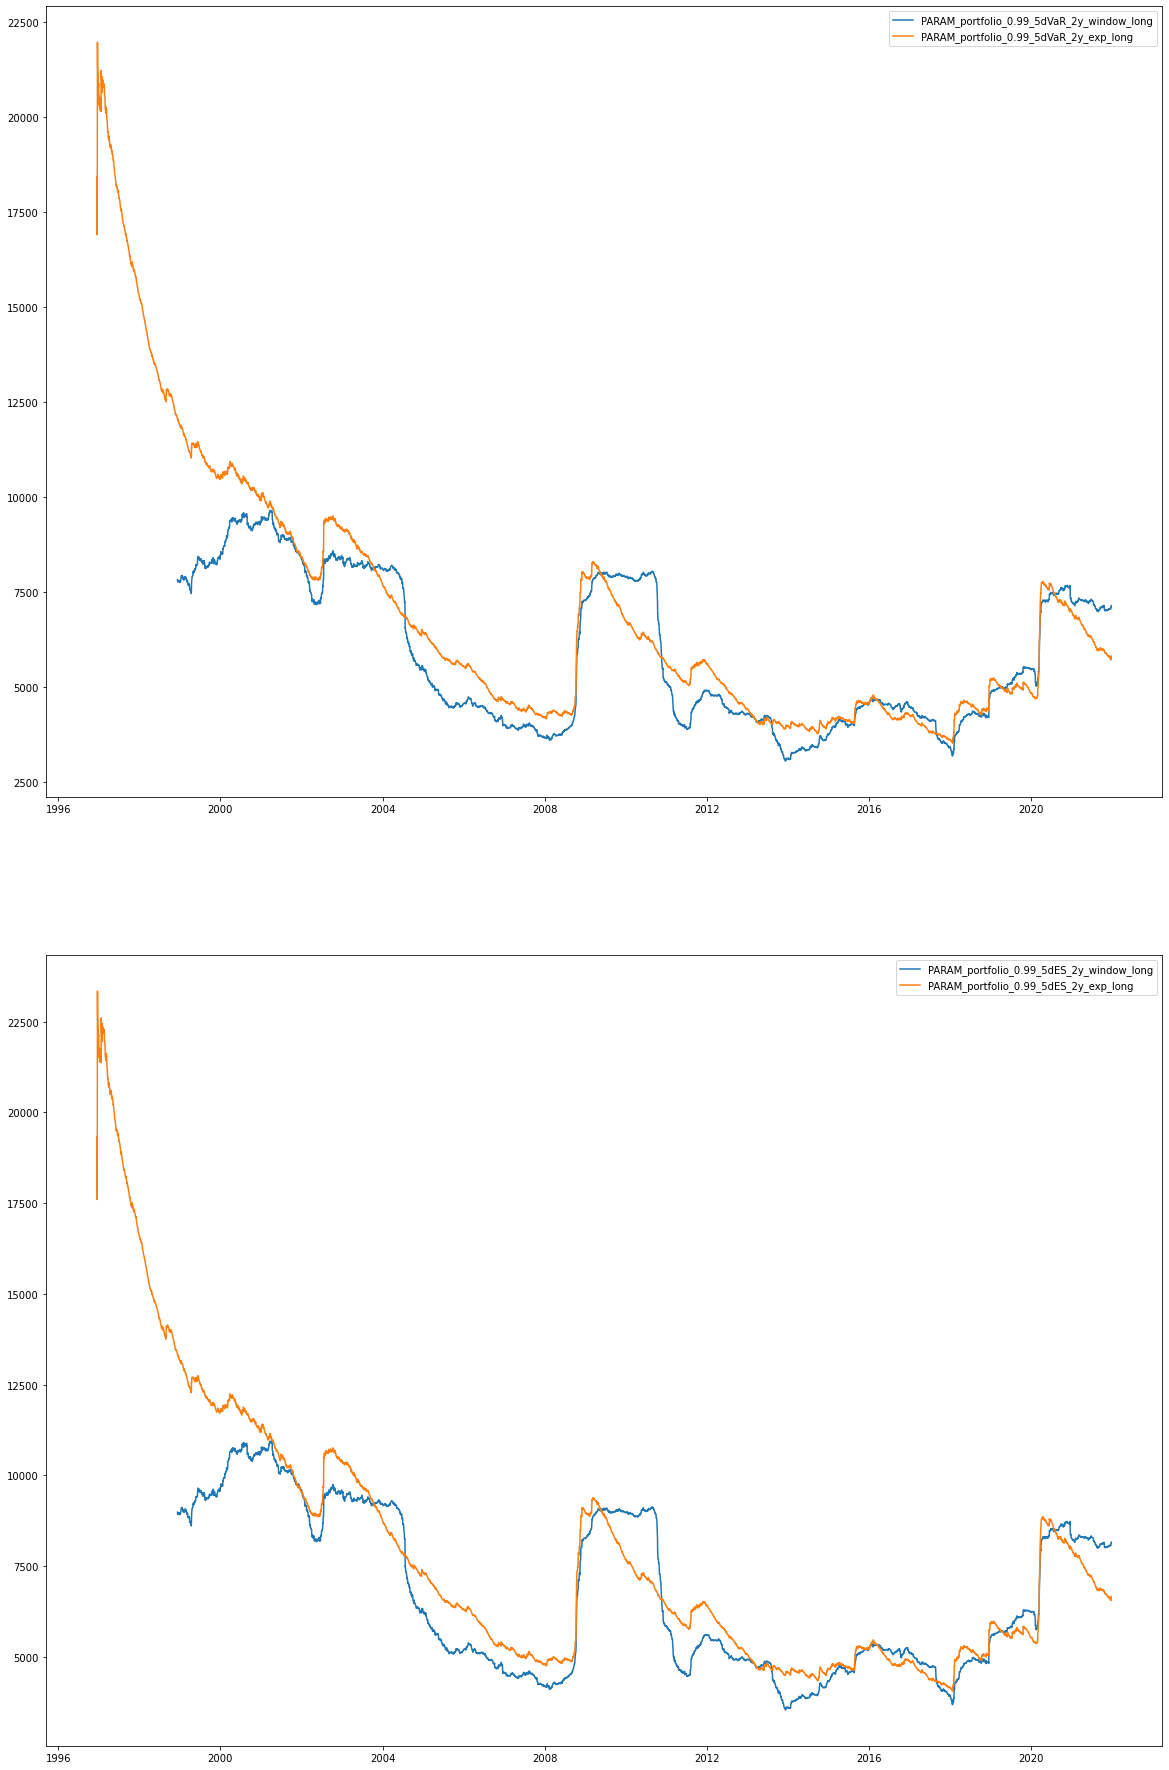

In [54]:
demo.fWinDiffMethodPlot(df, 'PARAM', 'portfolio', 0.99, 5, 2)

### Fixed Estimation Method and Position, Different Estimation Window

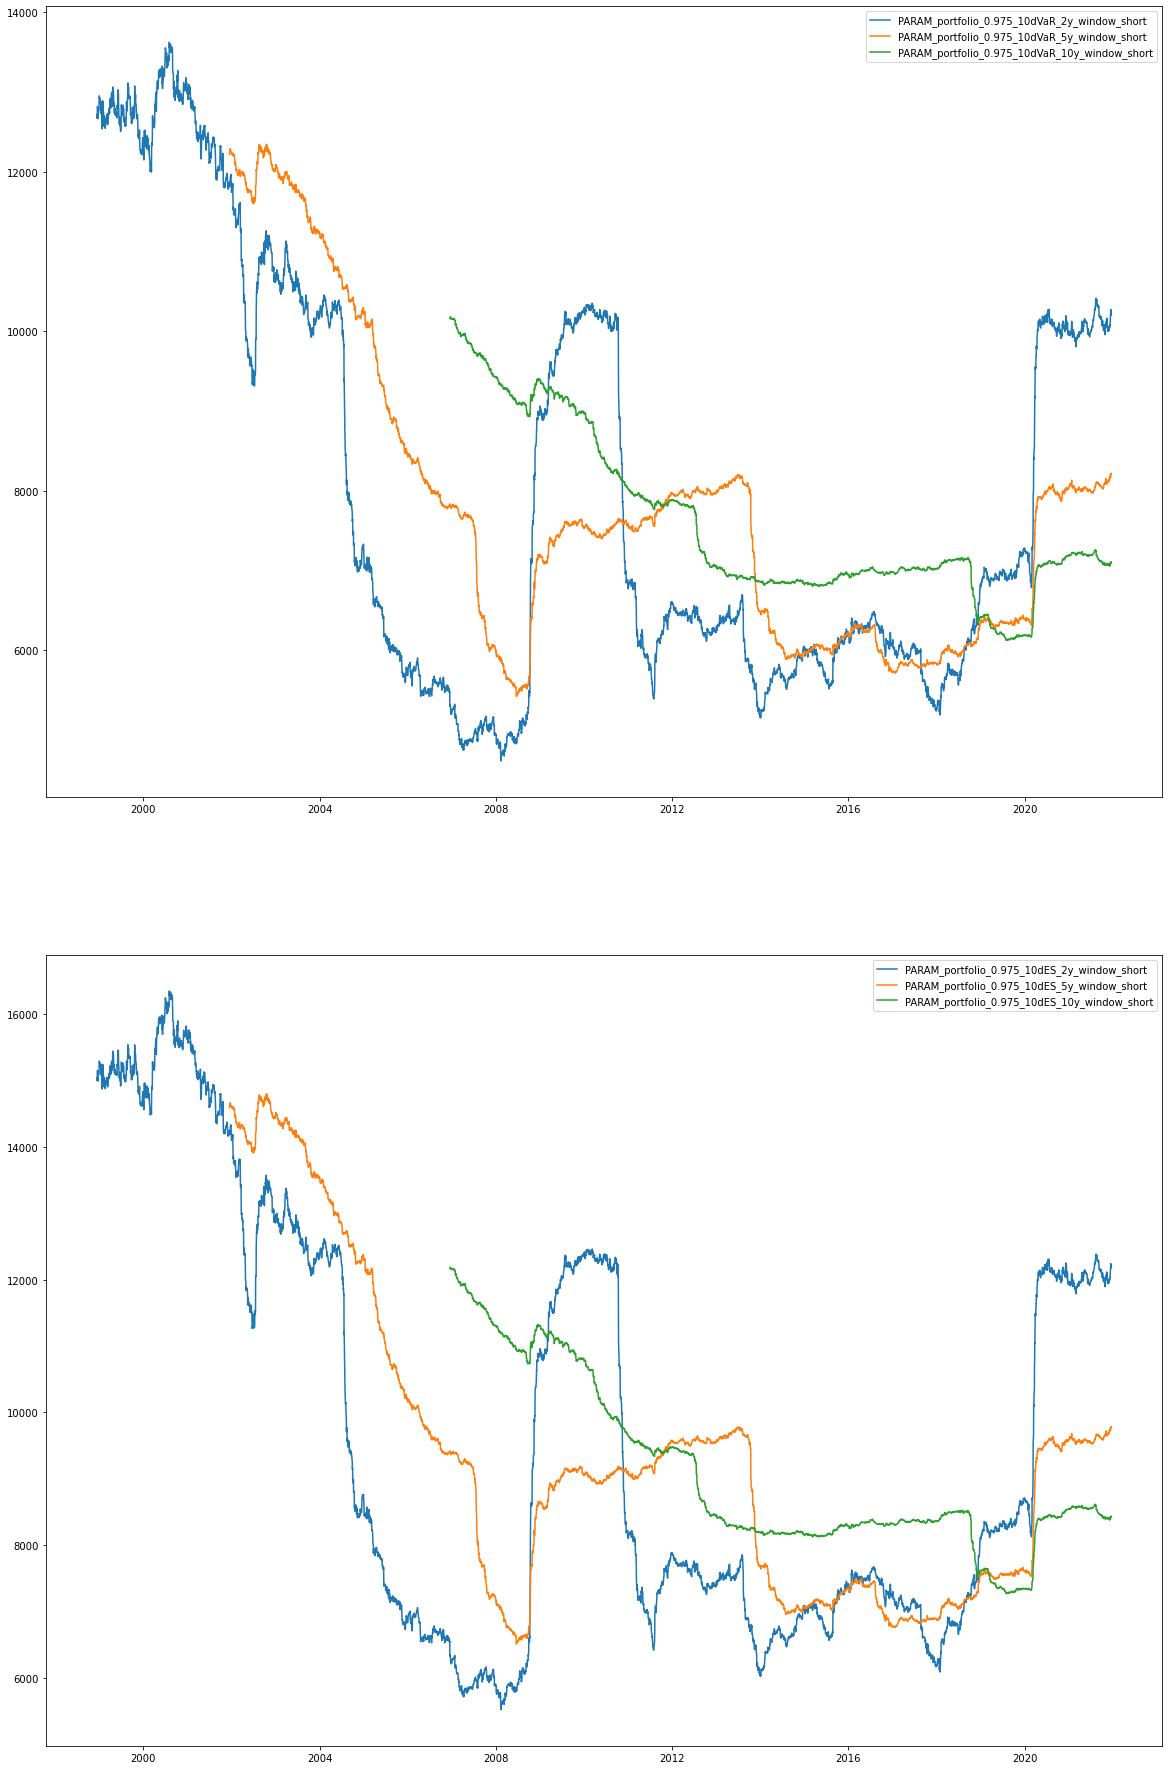

In [55]:
demo.fMethodDiffWinPlot(df, 'PARAM', 'portfolio', 0.975, 10, [2, 5, 10], 'window', 'short')

### Fixed Estimation Method and Window, Different Positions

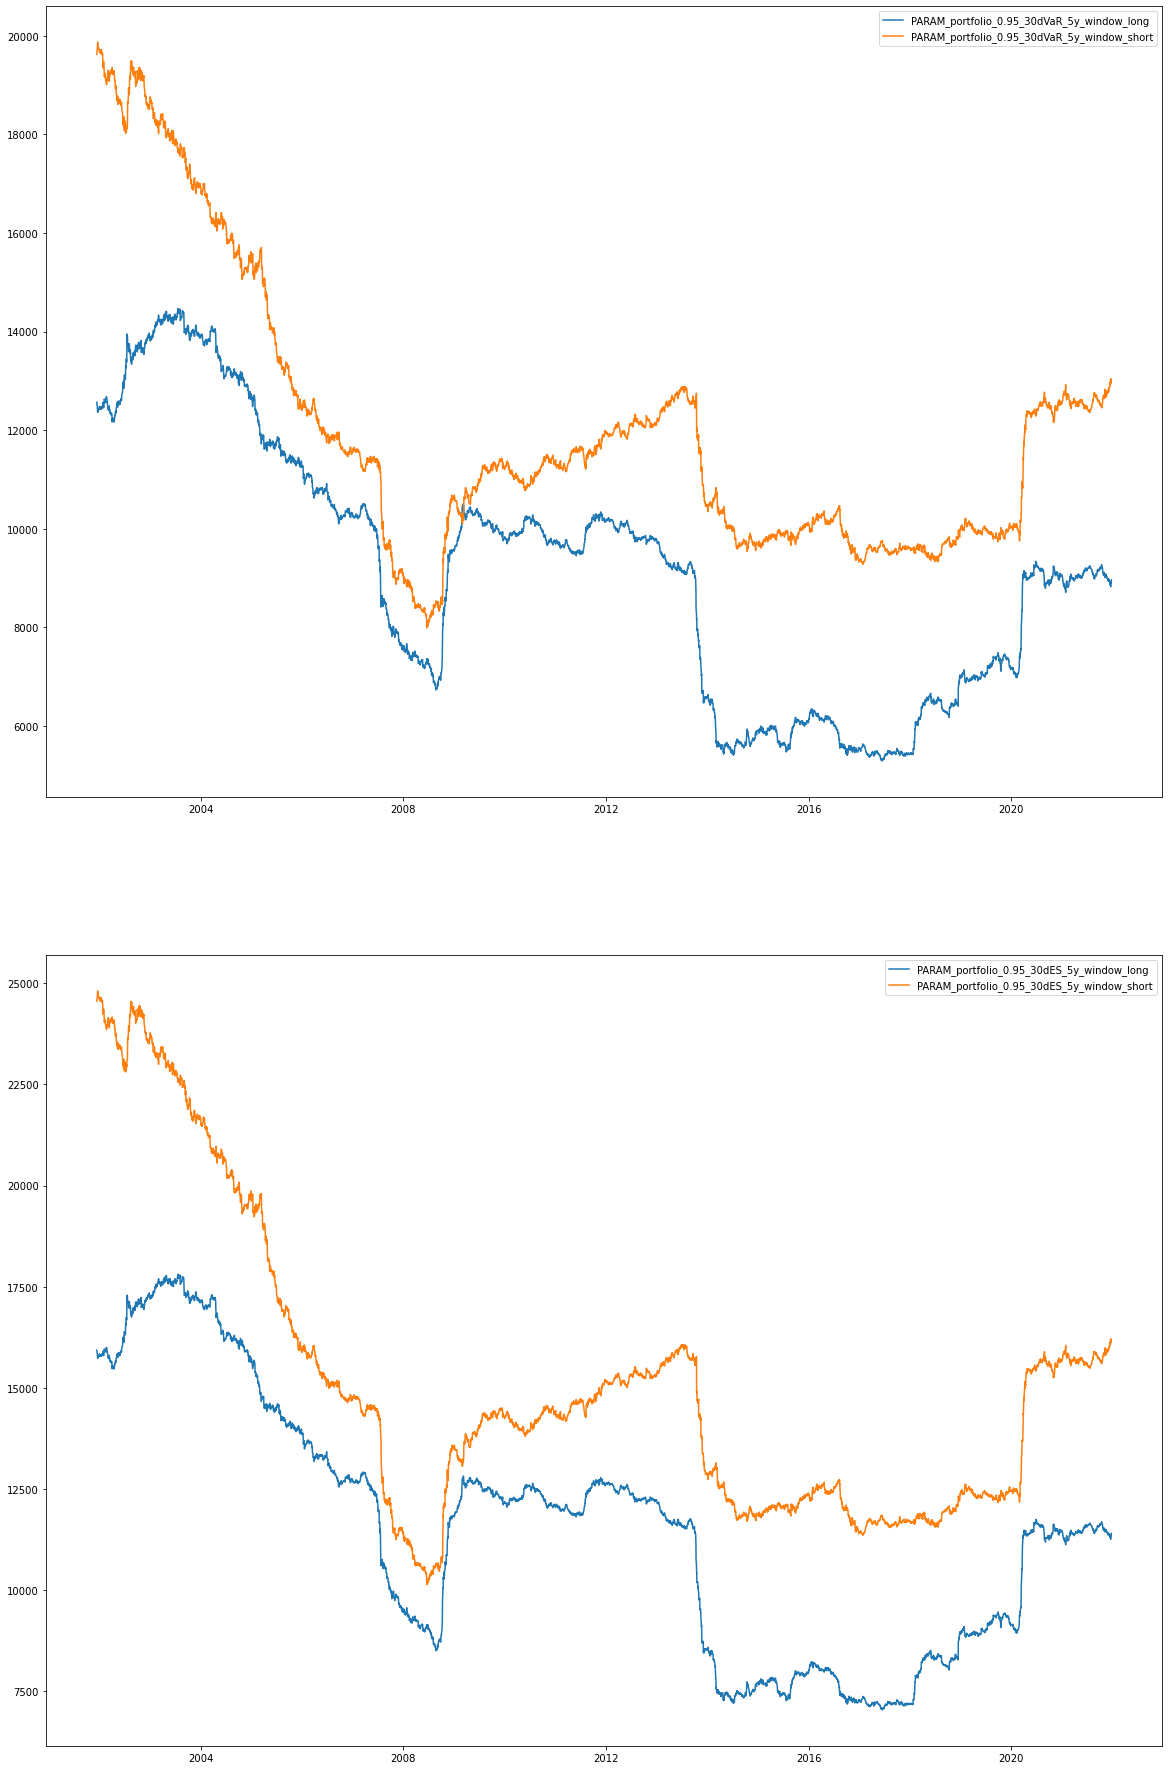

In [56]:
demo.fWinFMethodDiffPosition(df, 'PARAM', 'portfolio', 0.95, 30, 5, 'window')

## Monte Carlo Simulations


As was mentioned before, Monte Carlo simulations operate in a call-to-calculate manner. If you would like to get 5-day 99% VaR and ES, using 5-year window method when taking a long position, below is the command you are after. 

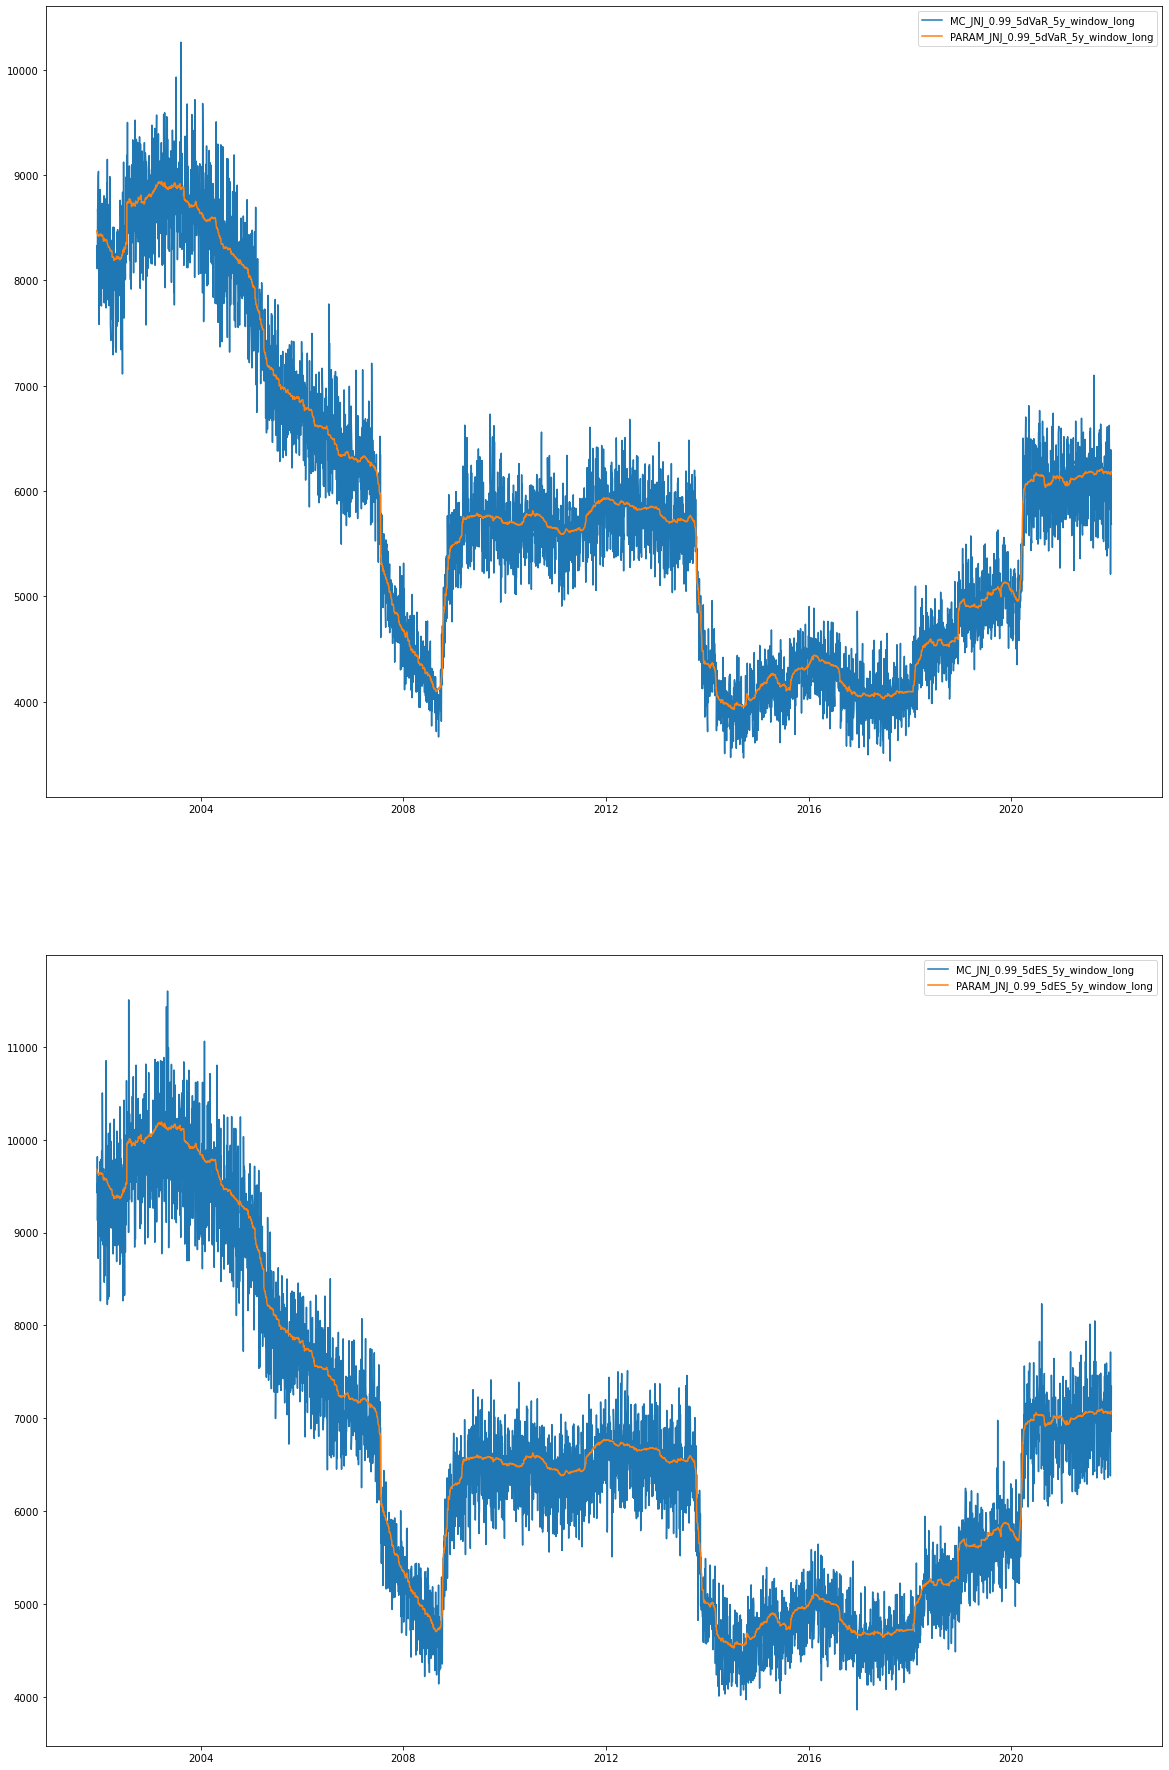

In [57]:
demo.paramMC(df, 'JNJ', 0.99, 5, 5, 'window', 'long')

## Historical
Calculate log returns with time intervals greater than 1 day. 

In [58]:
# Calculate log return as needed. (5-day, 10-day, 30-day log rtn)
for i in range(len(tickerList)): 
    for j in range(len(tList)): 
        dataFactory.logRtnCalc(df, tickerList[i], int(tList[j] * 252))

Here is an example of how you could use *dataFactory.HISTriskCalc()* to calculate 5-day 99% VaR and ES for JNJ, using past 5-year data. 

In [59]:
dataFactory.HISTriskCalc(df, 100000, 'JNJ', 0.99, 5 / 252, 5)

Comparison of parametric method, Monte Carlo simulations and historical method. 

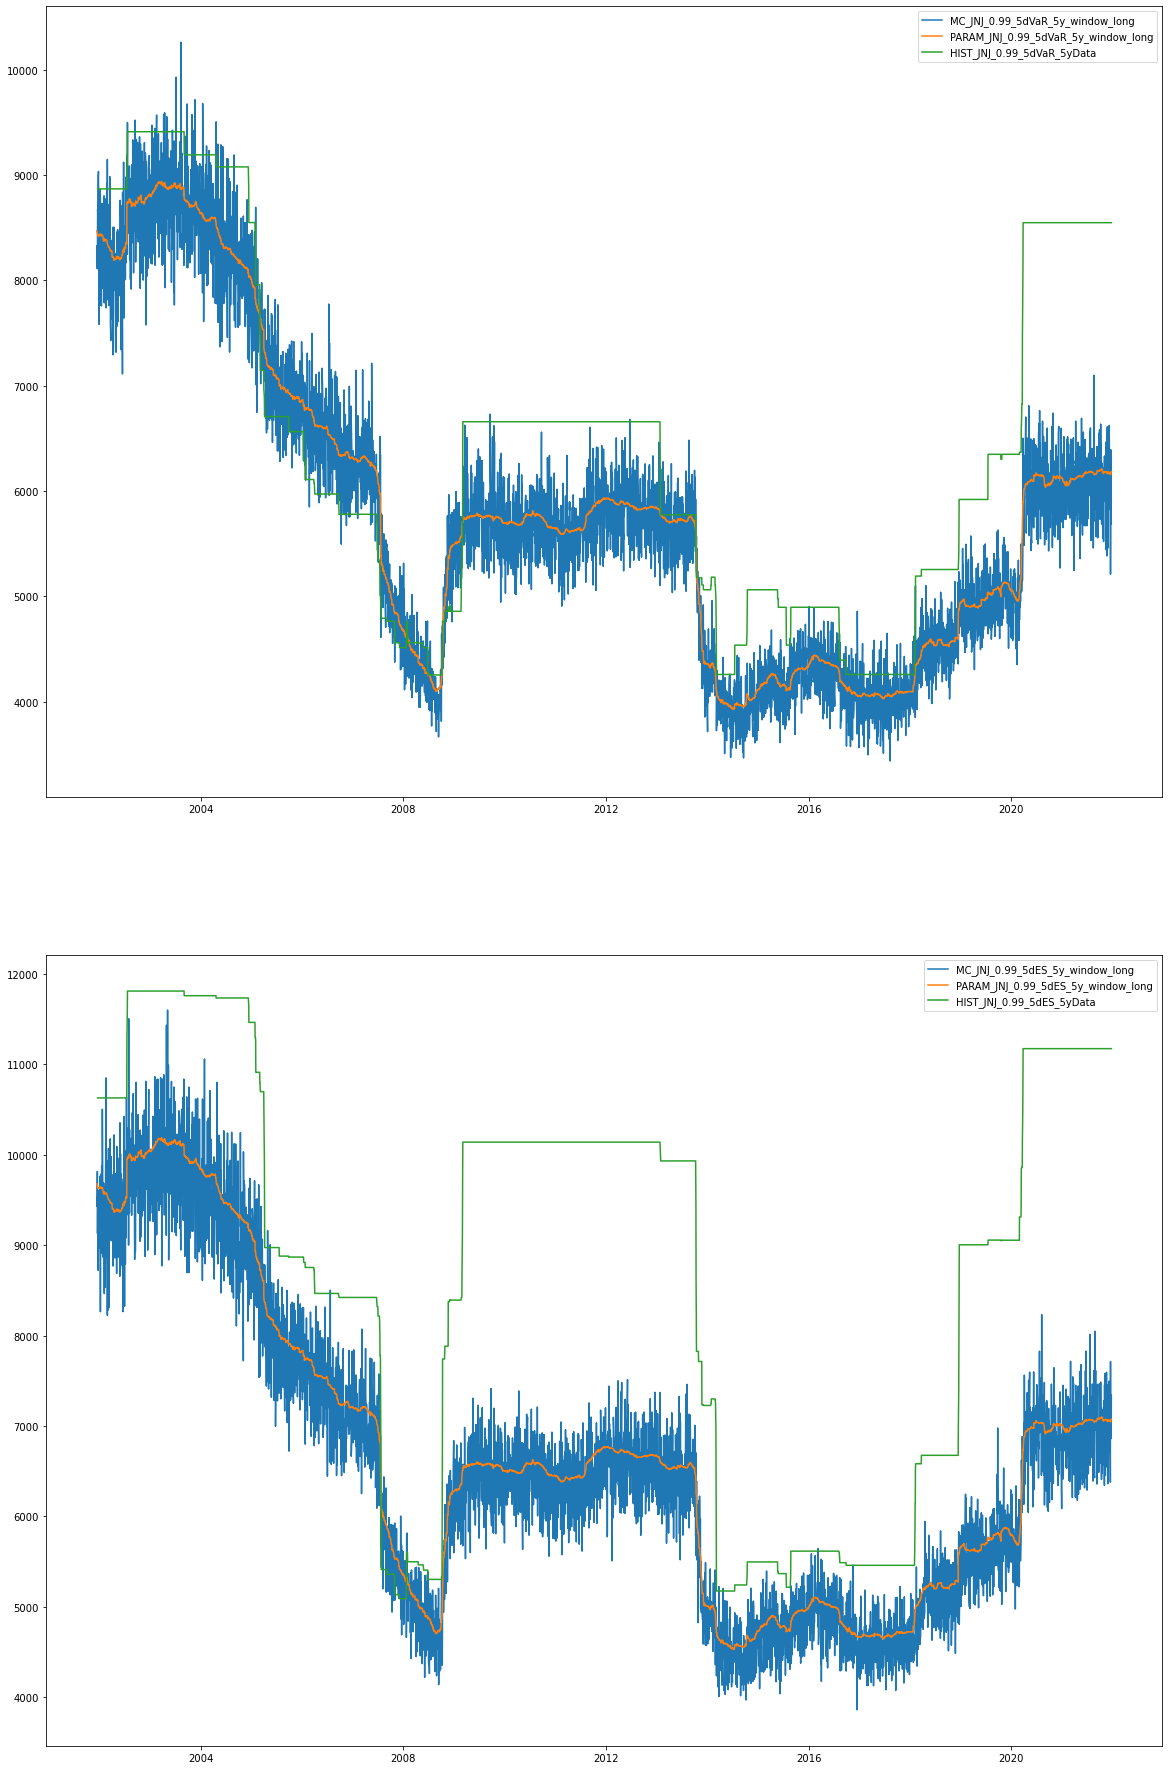

In [60]:
demo.PARAM_MC_HIST(df, 'JNJ', 0.99, 5, 5)

The cell below would calculate historical VaR and ES based on all possible combinations of parameters and store the results in the original dataframe. 

In [61]:
for i in range(len(tickerList)): 
    print("Started to calculate historical VaR and ES for:", tickerList[i])
    for j in range(len(pList)): 
        for m in range(len(tList)): 
            for n in range(len(windowList)): 
                dataFactory.HISTriskCalc(df, 100000, tickerList[i], pList[j], tList[m], windowList[n])

Started to calculate historical VaR and ES for: JNJ


KeyboardInterrupt: 

# Options
You can definitely liquidate part of the portfolios and buy put options to bring VaR down.   
Variable 'iv' below represents implied volatility. You can change it as you like.   

Below is the graph of the percentage you would need to liquidate to buy put options on different date.   

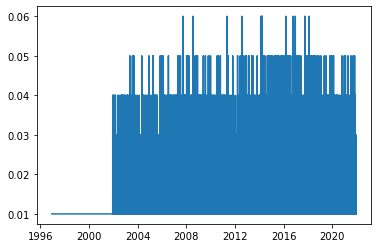

In [ ]:
iv = 0.2
dataFactory.targetLiquidate(df, 'JNJ', v0, 0.99, 5, iv)
plt.plot(df['liquidate_PARAM_JNJ_0.99_5dVaR_5y_window_long'])